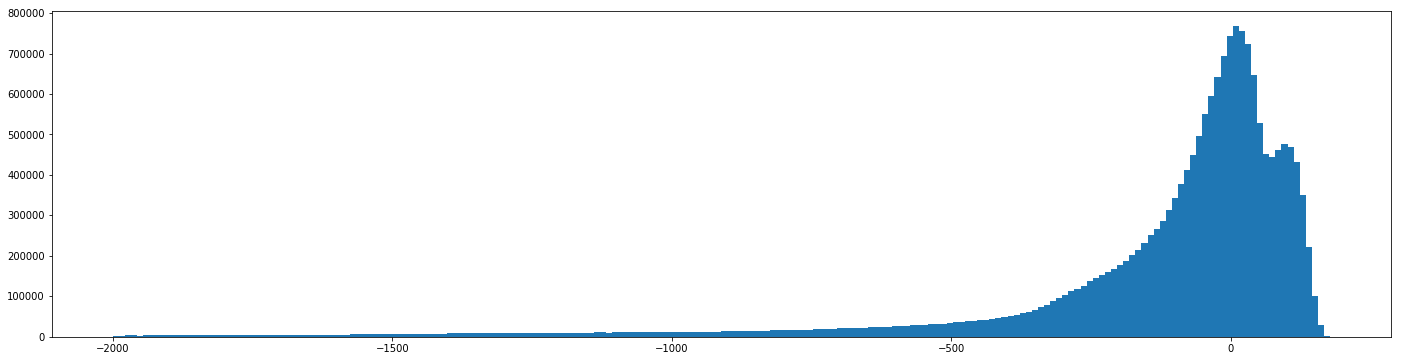

In [5]:
import os
import joblib
import numpy as np
import matplotlib as mplt

from skimage import io

from sklearn import metrics
from sklearn import decomposition

from matplotlib import pyplot as plt
from matplotlib import lines

from scipy import stats

%matplotlib inline

def plot_confusion_matrix(cm, classes, ax, title, cmap):
    
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=0.0, vmax=100.0)
    if title is not None:
        ax.set_title(title)
    
    # We want to show all ticks...
    ax.set(xticklabels=classes, yticklabels=classes,
           ylabel='Real Class',
           xlabel='Predicted Class')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")

'''
Classes:
    0 = Street
    1 = Building
    2 = Grass
    3 = Tree
    4 = Car
    5 = Surfaces
    6 = Boundaries
'''

##########################################################################################
##########################################################################################
##########################################################################################

epoch = 8000

# conv_name = 'unet'
# conv_name = 'fcnresnet50'
# conv_name = 'fcnresnext50'
# conv_name = 'fcnwideresnet50'
conv_name = 'fcndensenet121'
# conv_name = 'fcnvgg19'
# conv_name = 'fcnvgg19pretrained'
# conv_name = 'fcninceptionv3'
# conv_name = 'fcnmobilenetv2'
# conv_name = 'segnet'

dataset_name = 'Vaihingen'
# dataset_name = 'Potsdam'


n_known = 4
class_unk = 0
classes = ['', 'Building', 'Grass', 'Tree', 'Car', 'Unk. (Street)']

# n_known = 4
# class_unk = 1
# classes = ['', 'Street', 'Grass', 'Tree', 'Car', 'Unk. (Building)']

# n_known = 4
# class_unk = 2
# classes = ['', 'Street', 'Building', 'Tree', 'Car', 'Unk. (Grass)']

# n_known = 4
# class_unk = 3
# classes = ['', 'Street', 'Building', 'Grass', 'Car', 'Unk. (Tree)']

# n_known = 4
# class_unk = 4
# classes = ['', 'Street', 'Building', 'Grass', 'Tree', 'Unk. (Car)']

# n_known = 3
# class_unk = '0_1'
# classes = ['', 'Grass', 'Tree', 'Car', 'Unk. (Street/Building)']

# n_known = 3
# class_unk = '2_3'
# classes = ['', 'Street', 'Building', 'Car', 'Unk. (Grass/Tree)']

# n_known = 2
# class_unk = '0_1_4'
# classes = ['', 'Grass', 'Tree', 'Unk. (Street/Building/Car)']

# n_known = 2
# class_unk = '2_3_4'
# classes = ['', 'Street', 'Building', 'Unk. (Grass/Tree/Car)']

scr_dir = './outputs/%s_%s_openpca_new_%s/epoch_%d/' % (conv_name, dataset_name, str(class_unk), epoch)
img_dir = './outputs/%s_%s_openpca_%s/epoch_%d/' % (conv_name, dataset_name, str(class_unk), epoch)
# pkl_path = './outputs/%s_%s_openpca_new_%s/model_pca.pkl' % (conv_name, dataset_name, str(class_unk))

# print('Loading model from "%s"' % (pkl_path))
# dict_model = joblib.load(pkl_path)
# print(dict_model)
# params = dict_model['distribution']
# scr_thresholds = dict_model['thresholds']

# print('params', params)
# print('thresholds', scr_thresholds)
##########################################################################################
##########################################################################################

thresholds = [0.00, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30, 0.35, 0.40, 0.45,
              0.50, 0.55, 0.60, 0.65, 0.70, 0.75, 0.80, 0.85, 0.90, 0.95]

files = [f for f in os.listdir(scr_dir) if os.path.isfile(os.path.join(scr_dir, f)) and '_prev_' in f]

tru_list = []
pos_list = []
scr_list = []

for i, f in enumerate(files):

    img_path = os.path.join(img_dir, f.replace('_prev_', '_imag_'))
    tru_path = os.path.join(img_dir, f.replace('_prev_', '_true_'))
    pri_path = os.path.join(scr_dir, f)
    scr_path = os.path.join(scr_dir, f.replace('_prev_', '_scor_').replace('.png', '.npy'))

    try:
        img = io.imread(img_path)
        tru = io.imread(tru_path)
        pri = io.imread(pri_path)
        pos = np.copy(pri)
        scr = np.load(scr_path)
    except:
        print('Error in loading sample "' + f + '"')
        break

    tru_list.extend(tru.ravel().tolist())
    pos_list.extend(pos.ravel().tolist())
    scr_list.extend(scr.ravel().tolist())

scr_np = np.asarray(scr_list)

plt.figure(figsize=(24, 6))
plt.hist(scr_np[scr_np > -2000], bins=200)
plt.show()

length: 20471808, params: (0.4288568331108668, -0.0013580322265624996, 982.3478197502936)


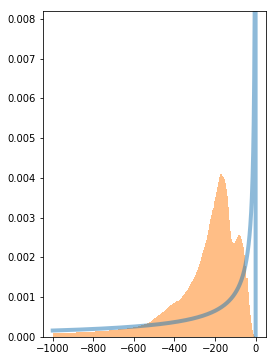

In [9]:
def fit_weibull(scr_np, thresholds):

    scr_t = []
#     param_list = []
    
    min_x = -1000
    
    # Fitting model and plotting thresholds and fits over histogram.
    fig, ax = plt.subplots(1, 1, figsize=(4, 6), sharey=True)

    # Fitting data.
    params = stats.weibull_max.fit(scr_np - scr_np.max(), loc=0,  scale=400)
    print('length: ' + str(scr_np.shape[0]) + ', params: ' + str(params))

    # Plotting axis.
    plot_x = np.linspace(min_x, 0, 2000)
    plot_y = stats.weibull_max.pdf(plot_x, *params)

    ax.plot(plot_x, plot_y, lw=4, alpha=0.5)
    bins = ax.hist(scr_np[scr_np > min_x] - scr_np.max(), bins=200, range=(min_x, 0), normed=True, alpha=0.5)
    ax.set_ylim(0, np.asarray(bins[0]).max() * 2)

    for i, t in enumerate(thresholds):
        x_threshold = stats.weibull_max.ppf(1.0 - t, *params)
        scr_t.append(x_threshold + scr_np.max())

#     root_metrics = './metrics/'
#     plot_path = os.path.join(root_metrics, args['architecture'], '%s_%s_%dcomp_trial_%d_weibull_fit.pdf' % (args['task_name'], args['gen_model'], args['num_components'], args['random_trial']))

#     fig.savefig(plot_path)

    plt.show()
    
    return scr_t, params

scr_thresholds, params = fit_weibull(scr_np, thresholds)

Threshold 0.95 - Acc. Known: 83.06%, Acc. Unk.: 60.06%, Pre. Unk.: 9.95%, Rec. Unk.: 0.00%, Balanced Acc.: 60.06%, Kappa: 47.56%


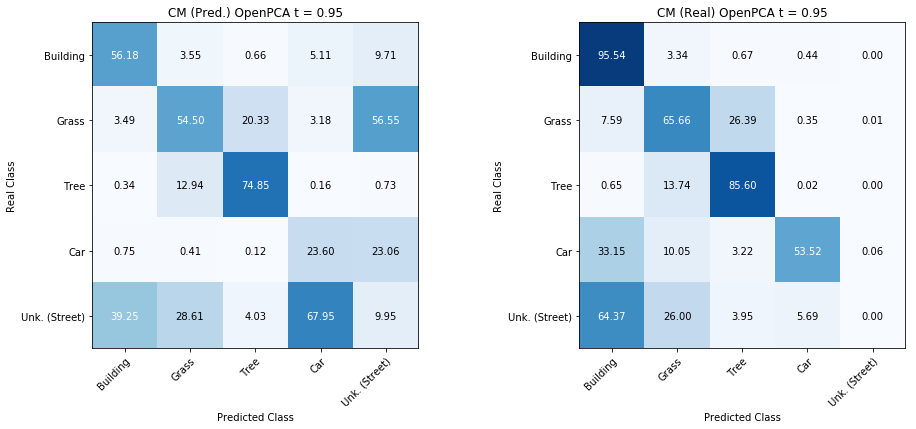

Threshold 0.90 - Acc. Known: 83.05%, Acc. Unk.: 60.08%, Pre. Unk.: 56.40%, Rec. Unk.: 0.10%, Balanced Acc.: 60.06%, Kappa: 47.59%


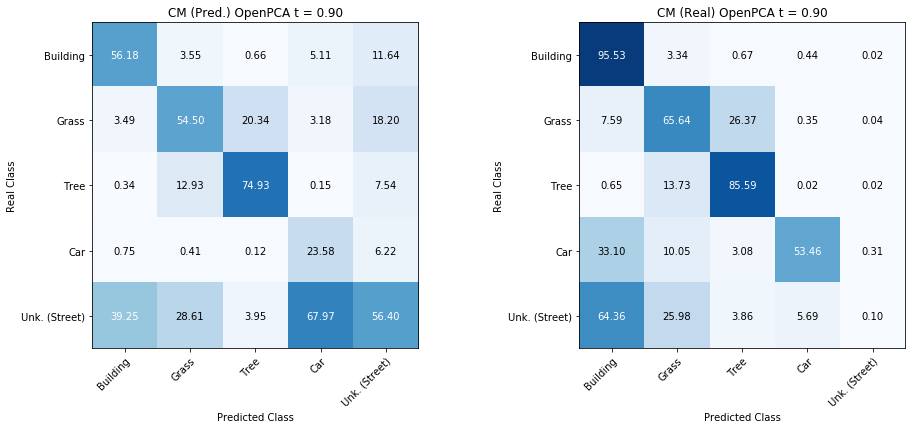

Threshold 0.85 - Acc. Known: 83.01%, Acc. Unk.: 60.16%, Pre. Unk.: 63.83%, Rec. Unk.: 0.49%, Balanced Acc.: 60.10%, Kappa: 47.69%


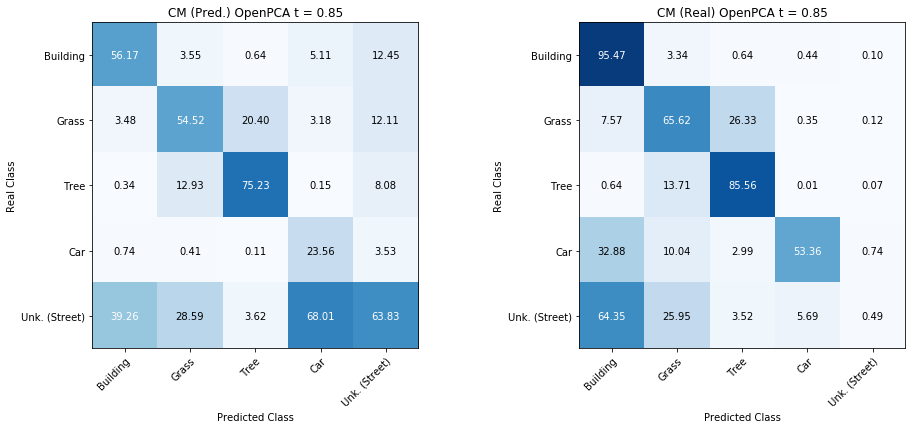

Threshold 0.80 - Acc. Known: 82.94%, Acc. Unk.: 60.26%, Pre. Unk.: 59.43%, Rec. Unk.: 1.02%, Balanced Acc.: 60.15%, Kappa: 47.81%


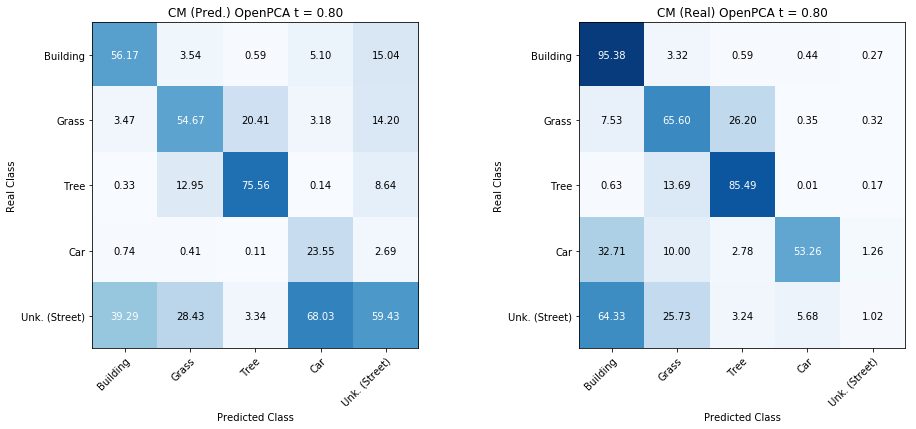

Threshold 0.75 - Acc. Known: 82.80%, Acc. Unk.: 60.71%, Pre. Unk.: 64.44%, Rec. Unk.: 3.01%, Balanced Acc.: 60.45%, Kappa: 48.37%


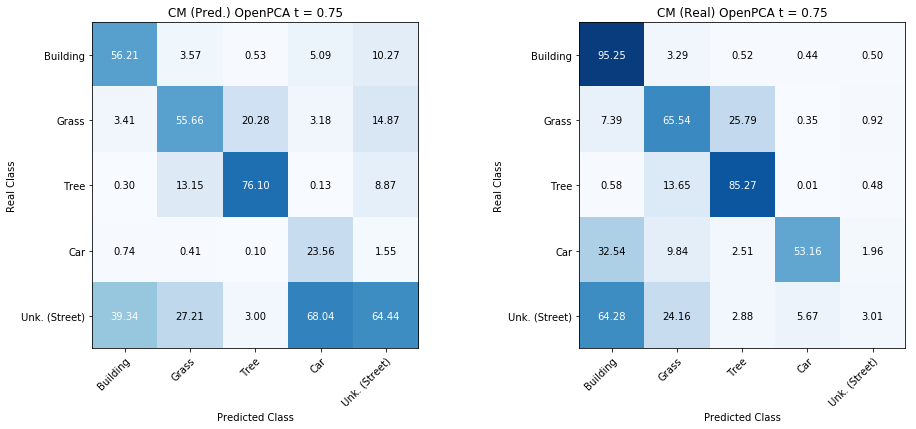

Threshold 0.70 - Acc. Known: 82.55%, Acc. Unk.: 61.76%, Pre. Unk.: 69.38%, Rec. Unk.: 7.47%, Balanced Acc.: 61.14%, Kappa: 49.69%


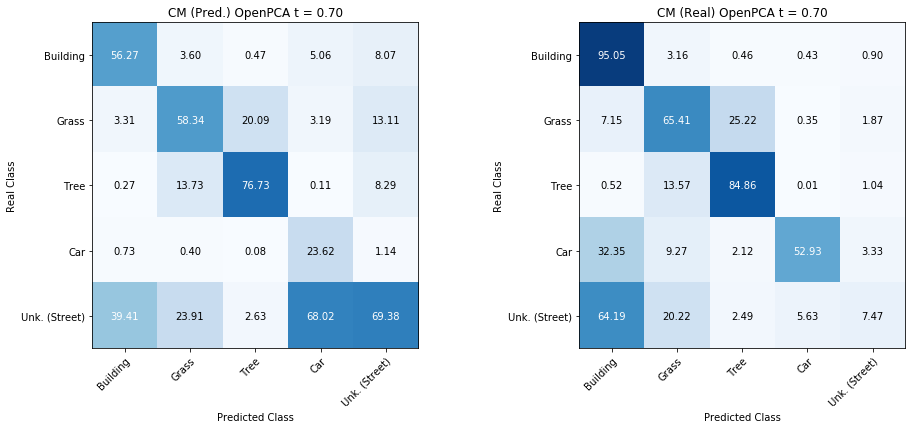

Threshold 0.65 - Acc. Known: 82.04%, Acc. Unk.: 62.74%, Pre. Unk.: 66.82%, Rec. Unk.: 12.36%, Balanced Acc.: 61.73%, Kappa: 50.90%


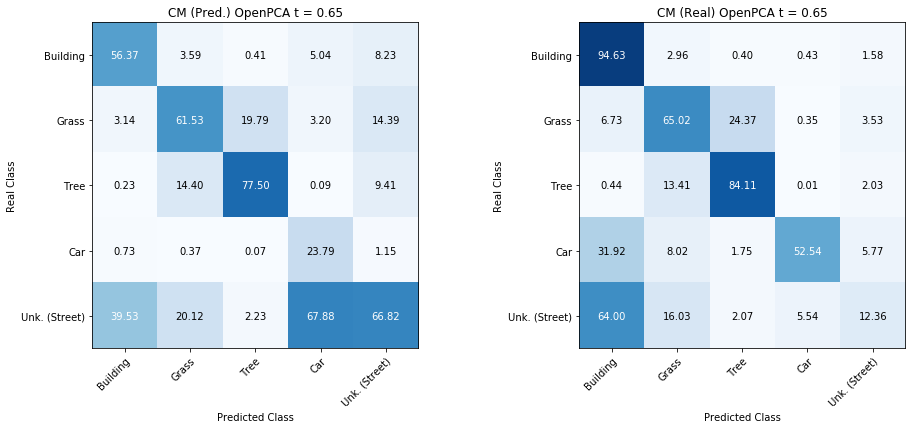

Threshold 0.60 - Acc. Known: 80.99%, Acc. Unk.: 63.10%, Pre. Unk.: 59.75%, Rec. Unk.: 16.40%, Balanced Acc.: 61.69%, Kappa: 51.29%


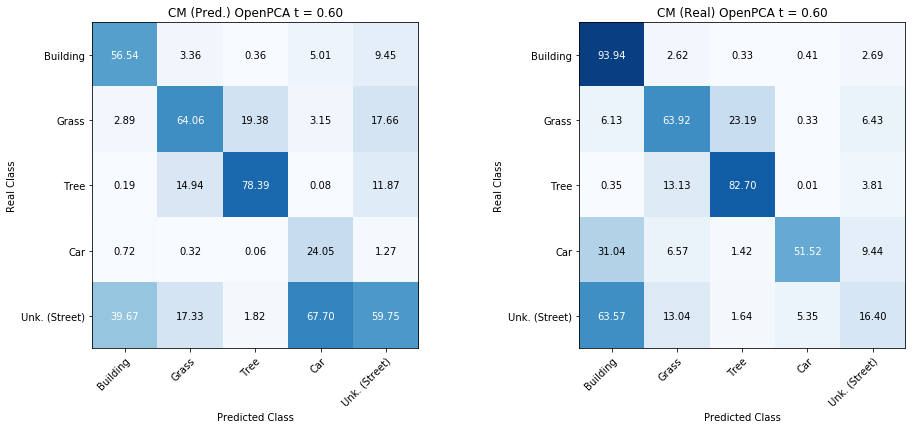

Threshold 0.55 - Acc. Known: 79.12%, Acc. Unk.: 62.96%, Pre. Unk.: 52.19%, Rec. Unk.: 20.78%, Balanced Acc.: 61.00%, Kappa: 50.99%


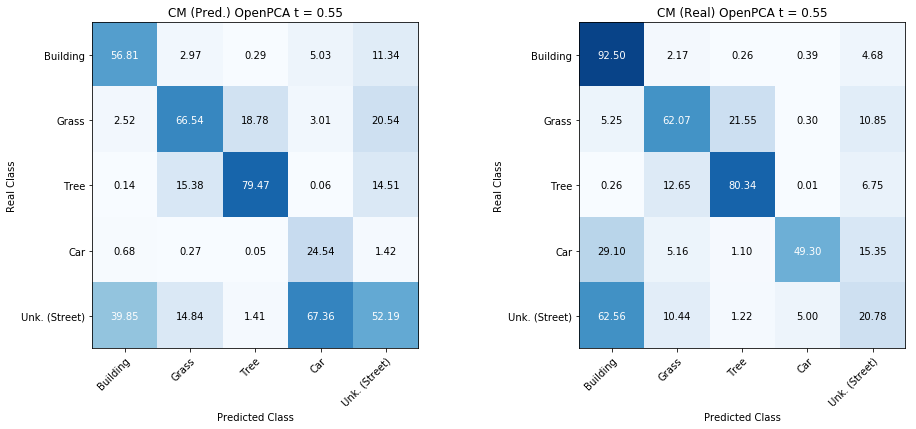

Threshold 0.50 - Acc. Known: 75.83%, Acc. Unk.: 64.02%, Pre. Unk.: 50.90%, Rec. Unk.: 33.16%, Balanced Acc.: 60.69%, Kappa: 52.21%


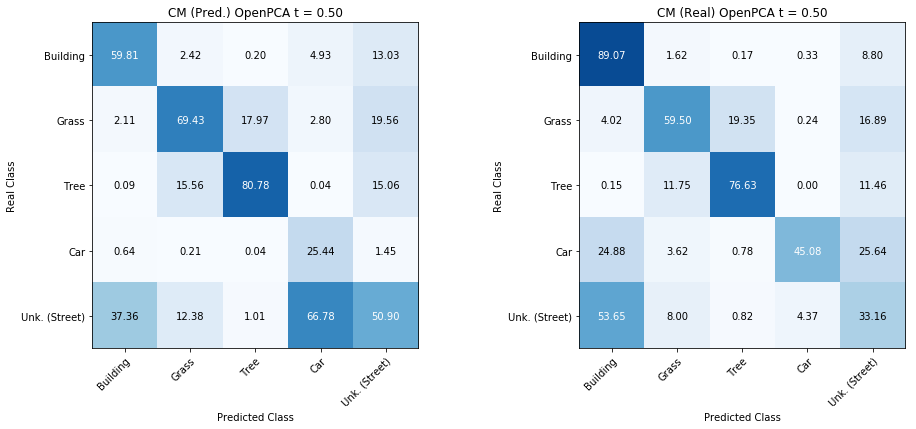

Threshold 0.45 - Acc. Known: 68.82%, Acc. Unk.: 64.71%, Pre. Unk.: 49.01%, Rec. Unk.: 53.98%, Balanced Acc.: 59.47%, Kappa: 52.89%


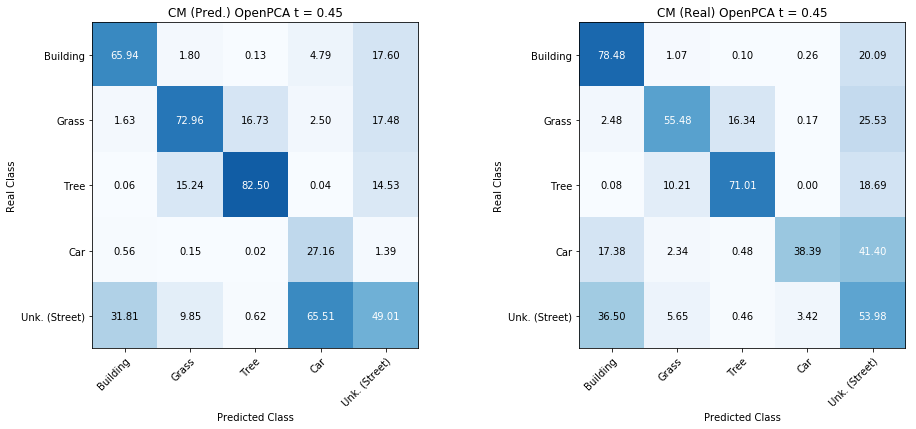

Threshold 0.40 - Acc. Known: 52.34%, Acc. Unk.: 59.27%, Pre. Unk.: 42.12%, Rec. Unk.: 77.36%, Balanced Acc.: 52.62%, Kappa: 45.20%


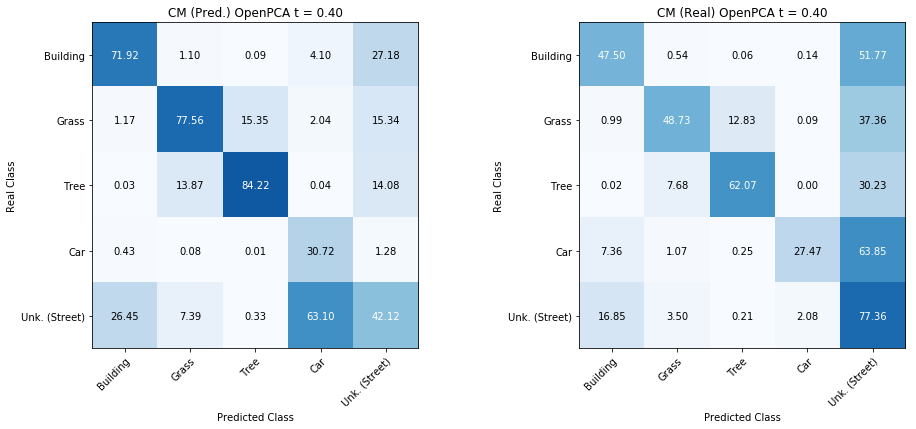

Threshold 0.35 - Acc. Known: 28.42%, Acc. Unk.: 47.32%, Pre. Unk.: 35.43%, Rec. Unk.: 96.70%, Balanced Acc.: 39.03%, Kappa: 28.36%


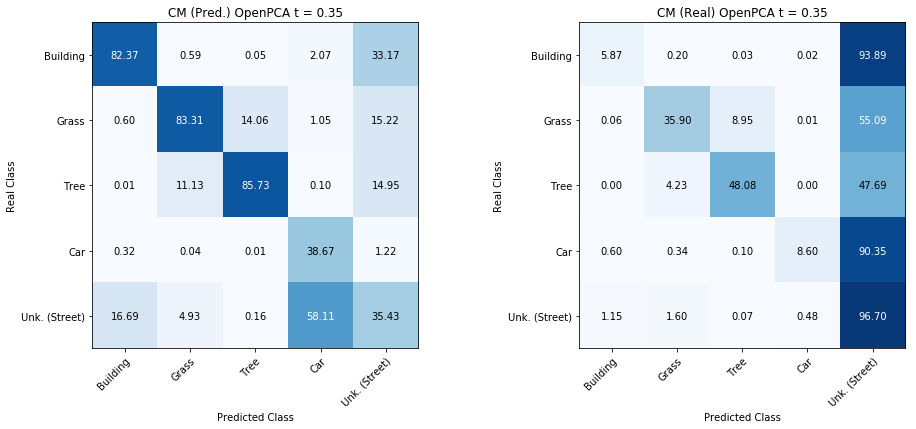

Threshold 0.30 - Acc. Known: 14.90%, Acc. Unk.: 38.35%, Pre. Unk.: 31.42%, Rec. Unk.: 99.58%, Balanced Acc.: 29.45%, Kappa: 15.45%


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in true_divide


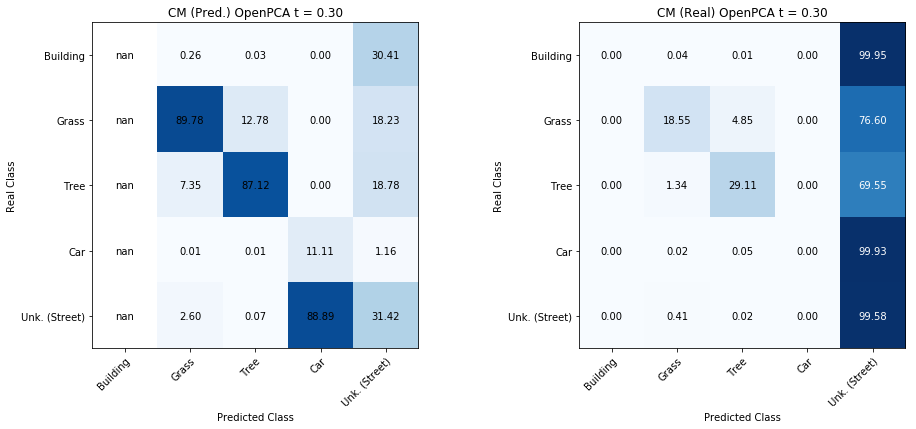

Threshold 0.25 - Acc. Known: 4.88%, Acc. Unk.: 31.21%, Pre. Unk.: 28.81%, Rec. Unk.: 99.96%, Balanced Acc.: 23.07%, Kappa: 5.11%


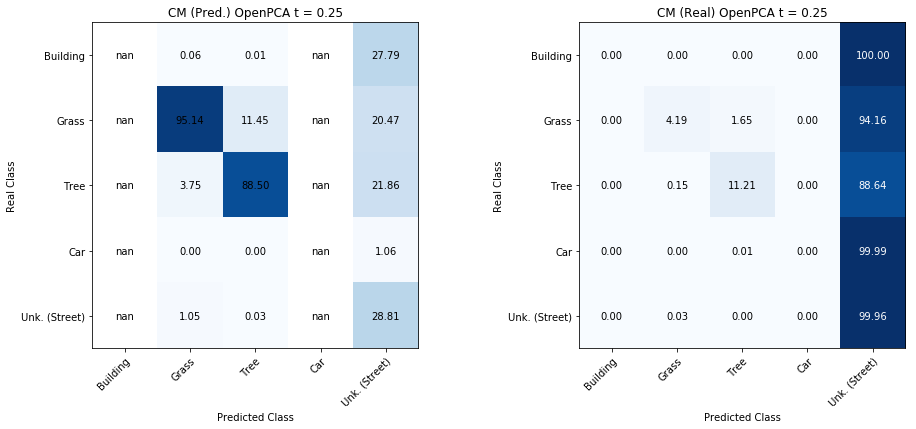

Threshold 0.20 - Acc. Known: 0.70%, Acc. Unk.: 28.20%, Pre. Unk.: 27.85%, Rec. Unk.: 100.00%, Balanced Acc.: 20.43%, Kappa: 0.74%


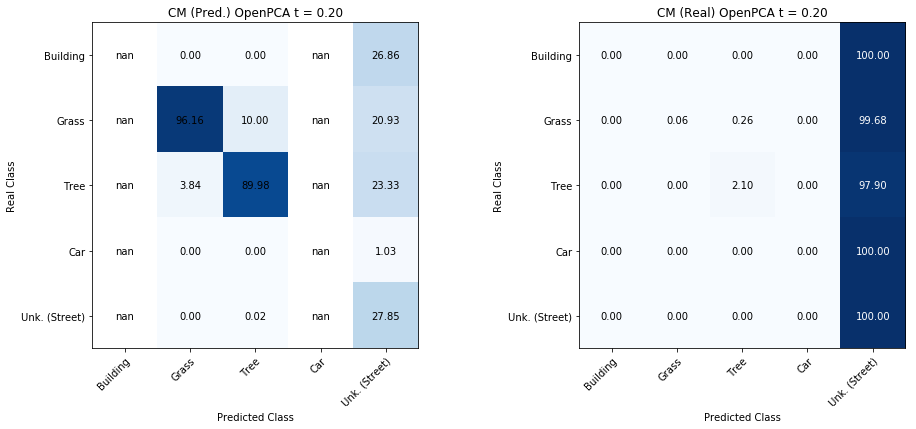

Threshold 0.15 - Acc. Known: 0.05%, Acc. Unk.: 27.73%, Pre. Unk.: 27.70%, Rec. Unk.: 100.00%, Balanced Acc.: 20.03%, Kappa: 0.06%


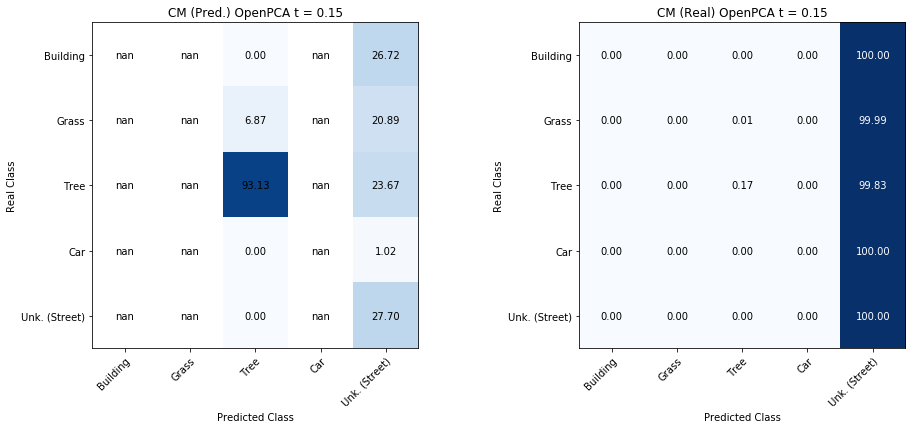

Threshold 0.10 - Acc. Known: 0.00%, Acc. Unk.: 27.69%, Pre. Unk.: 27.69%, Rec. Unk.: 100.00%, Balanced Acc.: 20.00%, Kappa: 0.00%


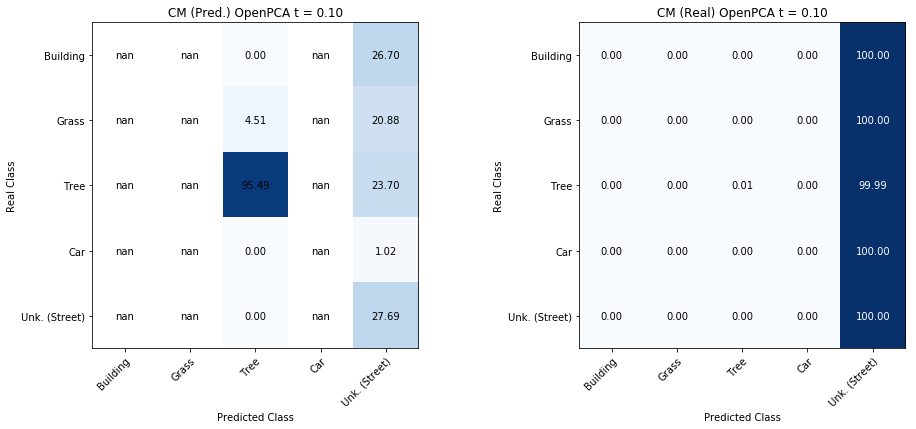

Threshold 0.05 - Acc. Known: 0.00%, Acc. Unk.: 27.69%, Pre. Unk.: 27.69%, Rec. Unk.: 100.00%, Balanced Acc.: 20.00%, Kappa: 0.00%


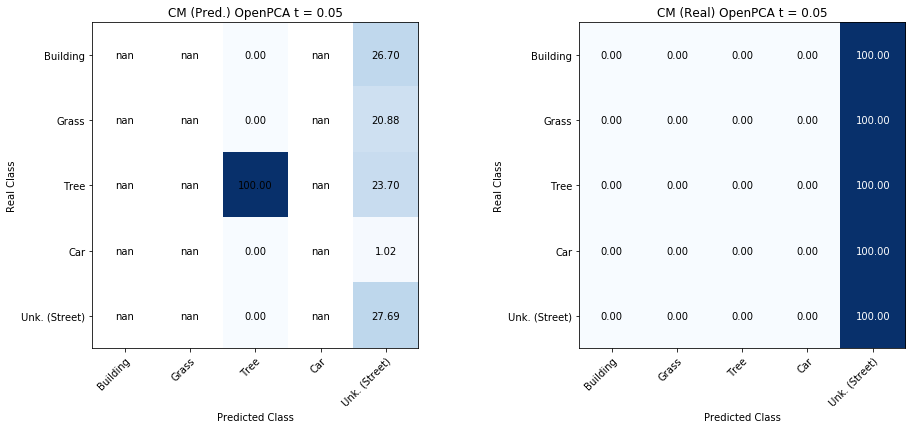

Threshold 0.00 - Acc. Known: 0.00%, Acc. Unk.: 27.69%, Pre. Unk.: 27.69%, Rec. Unk.: 100.00%, Balanced Acc.: 20.00%, Kappa: 0.00%


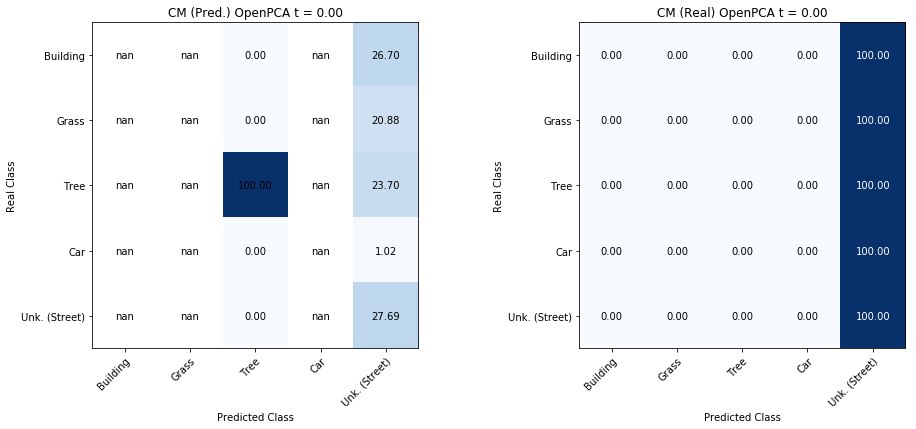

In [10]:
cm_list = []
acc_known_list = []
pre_unk_list = []
rec_unk_list = []
acc_unknown_list = []
acc_mean_list = []
acc_bal_list = []
kappa_list = []

tru_np = np.asarray(tru_list)
tru_valid = tru_np[tru_np < 5]

for t, scr_t in zip(reversed(thresholds), reversed(scr_thresholds)):
    
    pos_np = np.asarray(pos_list)

    pos_np[scr_np < scr_t] = n_known
    
    pos_valid = pos_np[tru_np < 5]
    
    cm = metrics.confusion_matrix(tru_valid, pos_valid)

    tru_known = 0.0
    sum_known = 0.0

    for c in range(n_known):
        tru_known += float(cm[c, c])
        sum_known += float(cm[c, :].sum())
    
    acc_known = float(tru_known) / float(sum_known)
    
    tru_unknown = float(cm[n_known, n_known])
    sum_unknown_real = float(cm[n_known, :].sum())
    sum_unknown_pred = float(cm[:, n_known].sum())

    pre_unknown = float(tru_unknown) / float(sum_unknown_pred)
    rec_unknown = float(tru_unknown) / float(sum_unknown_real)
    
    acc_unknown = (tru_known + tru_unknown) / (sum_known + sum_unknown_real)
    
    acc_mean = (acc_known + acc_unknown) / 2.0

    bal = metrics.balanced_accuracy_score(tru_valid, pos_valid)
    kap = metrics.cohen_kappa_score(tru_valid, pos_valid)

    print('Threshold %.2f - Acc. Known: %.2f%%, Acc. Unk.: %.2f%%, Pre. Unk.: %.2f%%, Rec. Unk.: %.2f%%, Balanced Acc.: %.2f%%, Kappa: %.2f%%' % (t, acc_known * 100.0, acc_unknown * 100.0, pre_unknown * 100.0, rec_unknown * 100.0, bal * 100.0, kap * 100.0))
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    
    cm_pred = cm.astype(np.float32)
    for c in range(n_known + 1):
        cm_pred[:(n_known + 1), c] /= cm_pred[:(n_known + 1), c].sum()
    plot_confusion_matrix(cm_pred[:(n_known + 1), :(n_known + 1)] * 100.0, classes, ax[0], 'CM (Pred.) OpenPCA t = %.2f' % (t), plt.cm.Blues)
    
    cm_real = cm.astype(np.float32)
    for c in range(n_known + 1):
        cm_real[c, :(n_known + 1)] /= cm_real[c, :(n_known + 1)].sum()
    plot_confusion_matrix(cm_real[:(n_known + 1), :(n_known + 1)] * 100.0, classes, ax[1], 'CM (Real) OpenPCA t = %.2f' % (t), plt.cm.Blues)
    
    plt.show()
    
    acc_known_list.append(acc_known)
    pre_unk_list.append(pre_unknown)
    rec_unk_list.append(rec_unknown)
    acc_unknown_list.append(acc_unknown)
    acc_mean_list.append(acc_mean)
    acc_bal_list.append(bal)
    kappa_list.append(kap)

thresholds = np.asarray(thresholds)
acc_known_list = np.asarray(acc_known_list) * 100
pre_unk_list = np.asarray(pre_unk_list) * 100
rec_unk_list = np.asarray(rec_unk_list) * 100
acc_unknown_list = np.asarray(acc_unknown_list) * 100
acc_mean_list = np.asarray(acc_mean_list) * 100
acc_bal_list = np.asarray(acc_bal_list) * 100
kappa_list = np.asarray(kappa_list) * 100

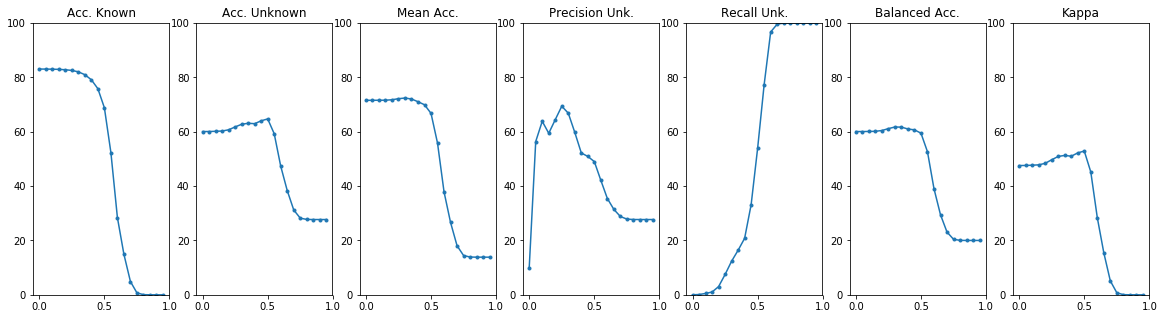

In [11]:
fig, ax = plt.subplots(1, 7, figsize=(20, 5))

ax[0].plot(thresholds, acc_known_list, '.-')
ax[0].set_title('Acc. Known')
ax[0].set_ylim([0, 100])

ax[1].plot(thresholds, acc_unknown_list, '.-')
ax[1].set_title('Acc. Unknown')
ax[1].set_ylim([0, 100])

ax[2].plot(thresholds, acc_mean_list, '.-')
ax[2].set_title('Mean Acc.')
ax[2].set_ylim([0, 100])

ax[3].plot(thresholds, pre_unk_list, '.-')
ax[3].set_title('Precision Unk.')
ax[3].set_ylim([0, 100])

ax[4].plot(thresholds, rec_unk_list, '.-')
ax[4].set_title('Recall Unk.')
ax[4].set_ylim([0, 100])

ax[5].plot(thresholds, acc_bal_list, '.-')
ax[5].set_title('Balanced Acc.')
ax[5].set_ylim([0, 100])

ax[6].plot(thresholds, kappa_list, '.-')
ax[6].set_title('Kappa')
ax[6].set_ylim([0, 100])

plt.show()

In [12]:
print('acc_known_list', acc_known_list)
print('acc_unknown_list', acc_unknown_list)
print('acc_mean_list', acc_mean_list)
print('pre_unk_list', pre_unk_list)
print('rec_unk_list', rec_unk_list)
print('acc_bal_list', acc_bal_list)
print('kappa_list', kappa_list)

for i in range(len(thresholds)):
    
    print('%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f\t%.2f' % (acc_known_list[i],
                                                        acc_unknown_list[i],
                                                        acc_mean_list[i],
                                                        pre_unk_list[i],
                                                        rec_unk_list[i],
                                                        acc_bal_list[i],
                                                        kappa_list[i]))

acc_known_list [8.30582591e+01 8.30450447e+01 8.30064292e+01 8.29414439e+01
 8.28049715e+01 8.25530820e+01 8.20367793e+01 8.09868496e+01
 7.91159292e+01 7.58339460e+01 6.88218793e+01 5.23441227e+01
 2.84160027e+01 1.48986551e+01 4.88464147e+00 7.04756600e-01
 5.43649404e-02 2.31608964e-03 9.26435856e-05 1.68442883e-05]
acc_unknown_list [60.05812927 60.07698359 60.15657243 60.25659897 60.70908429 61.7619785
 62.74279272 63.10028785 62.96126163 64.01570876 64.71058411 59.27153401
 47.32438919 38.34712806 31.21318696 28.20132561 27.7311735  27.69353794
 27.69193021 27.6918754 ]
acc_mean_list [71.55819418 71.56101417 71.58150082 71.59902146 71.75702791 72.15753027
 72.38978603 72.04356872 71.03859542 69.92482737 66.76623171 55.80782838
 37.87019595 26.62289157 18.04891422 14.45304111 13.89276922 13.84792702
 13.84601143 13.84594612]
pre_unk_list [ 9.95145631 56.39980825 63.83464657 59.43075507 64.43884222 69.38398806
 66.82464511 59.74864139 52.18624432 50.90414735 49.01015406 42.11613933
